In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

import random
import json
import ast
import os
import cv2
import PIL

from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew
import math

In [4]:
def rotate(image, angle, background):
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

In [70]:
components_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\deskewed"
cropped_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\cropped_true"

for n, image in zip(range(1244), os.listdir(cropped_path)):
    dir_img = os.path.join(cropped_path, image)
    photo = cv2.imread(os.path.join(dir_img))
    grayscale = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    try:
        rotated = rotate(photo, angle, (0, 0, 0))
    except:
        rotated = photo
    
    grayscale = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    vert = np.count_nonzero(np.sum(grayscale, axis=0))
    hor = np.count_nonzero(np.sum(grayscale, axis=1))
    
    if hor > vert:
        try:
            rotated = rotate(rotated, 90, (0, 0, 0))
        except:
            pass
    
    grayscale = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    vert = np.count_nonzero(np.sum(grayscale, axis=0))
    hor = np.count_nonzero(np.sum(grayscale, axis=1))
    
    if np.abs(hor - vert) < 100:
        try:
            rotated = rotate(rotated, 45, (0, 0, 0))
        except:
            pass
    
    grayscale = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    vert = np.count_nonzero(np.sum(grayscale, axis=0))
    hor = np.count_nonzero(np.sum(grayscale, axis=1))
    
    if hor > vert:
        try:
            rotated = rotate(rotated, 90, (0, 0, 0))
        except:
            pass
        
    grayscale = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    vert = np.nonzero(np.sum(grayscale, axis=0))
    hor = np.nonzero(np.sum(grayscale, axis=1))
    rotated = rotated[hor[0][0] : hor[0][-1], vert[0][0] : vert[0][-1]]
    
    cv2.imwrite(os.path.join(components_path , image), rotated)

In [4]:
test_char = r"C:\Users\Anton\Downloads\TlkWaterMeters\digits\id_1_value_13_116_3_1.jpg"

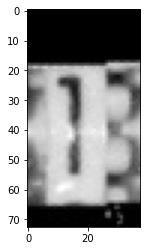

In [8]:
image = cv2.imread(test_char)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap="gray")

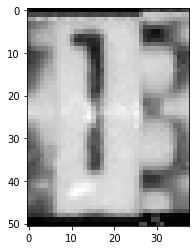

In [28]:
w = len(image[0])
non_zeros_n = np.count_nonzero(image, axis=1)
plt.imshow(image[np.where(non_zeros_n >= 0.8*w)[0]], cmap="gray")

In [301]:
# 8 digits
test_img = r"C:\Users\Anton\Downloads\TlkWaterMeters\deskewed\id_851_value_305_162.jpg"

In [335]:
# 5 digits
test_img = r"C:\Users\Anton\Downloads\TlkWaterMeters\deskewed\id_839_value_1025_0.jpg"

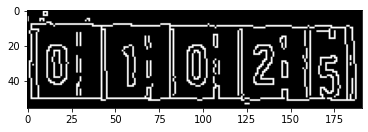

In [336]:
image = cv2.imread(test_img)
edges = cv2.Canny(image, 100, 200, L2gradient=True)
plt.imshow(edges,cmap = 'gray')

In [337]:
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [338]:
filtered = [];
low = 50
high = 700;
for con in contours:
    area = cv2.contourArea(con);
    if low < area and area < high:
        filtered.append(con)

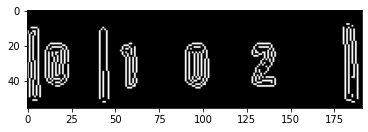

In [339]:
h, w = edges.shape
blank_image = np.zeros((h,w,3), np.uint8)
cv2.drawContours(blank_image, filtered, -1, (0,255,0), 1)
new_edges = cv2.Canny(blank_image, 100, 200, L2gradient=True)
plt.imshow(new_edges,cmap = 'gray')

In [340]:
# print("Shapes: " + str(len(filtered)));
# for con in filtered:
#     M = cv2.moments(con);
#     cx = int(M['m10']/M['m00']);
#     cy = int(M['m01']/M['m00']);
#     cv2.circle(image, (cx, cy), 10, (0, 200, 100), -1);

# plt.imshow(image);

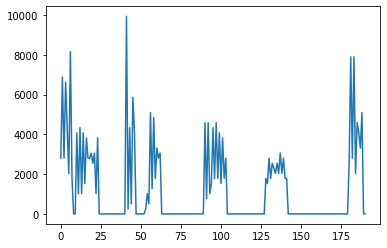

In [341]:
# new_edges = new_edges/255
vsum = np.sum(new_edges, axis=0)
plt.plot(vsum)
# из временных рядов найти периодичность (попробовать)
# pct_change

In [290]:
def zero_runs(a):
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [289]:
indices = zero_runs(vsum).flatten()[1:-1]
pairs = list(zip(indices[::2], indices[1::2]))
pairs

[(15, 38),
 (56, 74),
 (93, 110),
 (129, 148),
 (166, 184),
 (204, 215),
 (239, 259),
 (275, 295)]

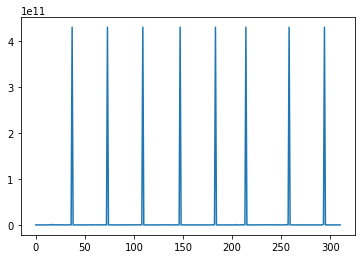

In [276]:
plt.plot(np.diff(vsum) / (vsum[1:]+1) * 100)

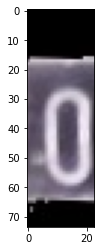

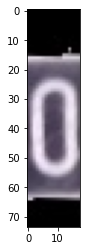

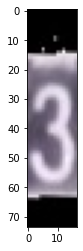

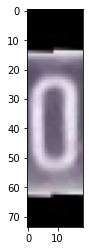

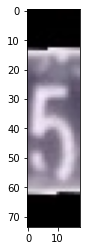

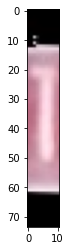

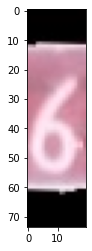

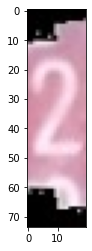

In [291]:
chars = []
for left, right in pairs:
    plt.figure()
    cimgI = image[:, left:right]
    chars.append(cimgI)
    plt.imshow(cimgI)

In [2]:
def split_by_digits(image):
    edges = cv2.Canny(image, 100, 200, L2gradient=True)
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    filtered = [];
    low = 50
    high = 700;
    for con in contours:
        area = cv2.contourArea(con);
        if low < area and area < high:
            filtered.append(con)
            
    h, w = edges.shape
    blank_image = np.zeros((h,w,3), np.uint8)
    cv2.drawContours(blank_image, filtered, -1, (0,255,0), 1)
    new_edges = cv2.Canny(blank_image, 100, 200, L2gradient=True)
    
    vsum = np.sum(new_edges, axis=0)
    
    indices = zero_runs(vsum).flatten()[1:-1]
    pairs = list(zip(indices[::2], indices[1::2]))
    
    chars = []
    for left, right in pairs:
        cimgI = image[:, left:right]
        chars.append(cimgI)
#         plt.imshow(cimgI)

    return chars

In [334]:
deskewed_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\deskewed"
digits_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\digits_wrong"

for n, image in zip(range(1244), os.listdir(deskewed_path)):
    dir_img = os.path.join(deskewed_path, image)
    photo = cv2.imread(os.path.join(dir_img))
    
    chars = split_by_digits(photo)
#     print(len(chars))
    for idx, char in enumerate(chars):
#         print(1)
        cv2.imwrite(os.path.join(digits_path, image[:-4]+"_"+str(idx)+".jpg"), char)

In [30]:
with open(r"C:\Users\Anton\Downloads\TlkWaterMeters\5 digits", "r") as file:
    lines = file.readlines()
    digits5 = [line.strip("\n") for line in lines]
    
with open(r"C:\Users\Anton\Downloads\TlkWaterMeters\7 digits", "r") as file:
    lines = file.readlines()
    digits7 = [line.strip("\n") for line in lines]
    
with open(r"C:\Users\Anton\Downloads\TlkWaterMeters\reversed", "r") as file:
    lines = file.readlines()
    revers = [line.strip("\n") for line in lines]

In [32]:
data = pd.read_csv(r"C:\Users\Anton\Downloads\TlkWaterMeters\data.tsv", sep='\t', header=0)
data.head()

,photo_name,value,location
0,id_53_value_595_825.jpg,595.825,"{'type': 'polygon', 'data': [{'x': 0.30788, 'y..."
1,id_553_value_65_475.jpg,65.475,"{'type': 'polygon', 'data': [{'x': 0.26133, 'y..."
2,id_407_value_21_86.jpg,21.860,"{'type': 'polygon', 'data': [{'x': 0.27545, 'y..."
3,id_252_value_313_322.jpg,313.322,"{'type': 'polygon', 'data': [{'x': 0.21967, 'y..."
4,id_851_value_305_162.jpg,305.162,"{'type': 'polygon', 'data': [{'x': 0.06983, 'y..."


In [33]:
data[data['photo_name'] == "id_1000_value_176_881.jpg"].value.to_numpy()[0]

176.881

In [34]:
''.join(str(data[data['photo_name'] == "id_53_value_595_825.jpg"].value[0]).split('.')).zfill(8)

'00595825'

In [35]:
deskewed_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\deskewed"
digits_path = r"C:\Users\Anton\Downloads\TlkWaterMeters\digits"

for n, image in zip(range(1244), os.listdir(deskewed_path)):
    dir_img = os.path.join(deskewed_path, image)
    photo = cv2.imread(os.path.join(dir_img))
    photo = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    
    num = 8
    if image in digits5:
        num = 5
        
    if image in digits7:
        num = 7
        
#     print(image)
    value = ''.join(str(data[data['photo_name'] == image].value.to_numpy()[0]).split('.')).zfill(num)
    
    if image in revers:
        value = value[::-1]
    
    chars = np.array_split(photo, num, axis=1)
#     print(len(chars))
    for idx, (val, char) in enumerate(zip(value, chars)):
        w = len(char[0])
        non_zeros_n = np.count_nonzero(char, axis=1)
        char = char[np.where(non_zeros_n >= 0.8*w)[0]]
        
        cv2.imwrite(os.path.join(digits_path, image[:-4]+"_"+str(idx)+"_"+val+".jpg"), char)